In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

import tensorflow as tf

from sklearn.metrics import confusion_matrix, classification_report

In [3]:
data = pd.read_json('../input/news-category-dataset/News_Category_Dataset_v2.json', lines=True)
#https://www.kaggle.com/rmisra/news-category-dataset

In [4]:
data.head()


### category is the target
### headline, short_description will only be helpful

,category,headline,authors,link,short_description,date
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26


In [5]:
data.category[2], data.short_description[2]

## so bith cols can be used

('ENTERTAINMENT',
 'The actor and his longtime girlfriend Anna Eberstein tied the knot in a civil ceremony.')

In [6]:
### encoding
cat_idx= dict((cat,idx) for idx, cat in enumerate(data.category.unique()))
cat_idx

{'CRIME': 0,
 'ENTERTAINMENT': 1,
 'WORLD NEWS': 2,
 'IMPACT': 3,
 'POLITICS': 4,
 'WEIRD NEWS': 5,
 'BLACK VOICES': 6,
 'WOMEN': 7,
 'COMEDY': 8,
 'QUEER VOICES': 9,
 'SPORTS': 10,
 'BUSINESS': 11,
 'TRAVEL': 12,
 'MEDIA': 13,
 'TECH': 14,
 'RELIGION': 15,
 'SCIENCE': 16,
 'LATINO VOICES': 17,
 'EDUCATION': 18,
 'COLLEGE': 19,
 'PARENTS': 20,
 'ARTS & CULTURE': 21,
 'STYLE': 22,
 'GREEN': 23,
 'TASTE': 24,
 'HEALTHY LIVING': 25,
 'THE WORLDPOST': 26,
 'GOOD NEWS': 27,
 'WORLDPOST': 28,
 'FIFTY': 29,
 'ARTS': 30,
 'WELLNESS': 31,
 'PARENTING': 32,
 'HOME & LIVING': 33,
 'STYLE & BEAUTY': 34,
 'DIVORCE': 35,
 'WEDDINGS': 36,
 'FOOD & DRINK': 37,
 'MONEY': 38,
 'ENVIRONMENT': 39,
 'CULTURE & ARTS': 40}

In [7]:
data.category.value_counts()
### we sample 1000 from each sample

POLITICS          32739
WELLNESS          17827
ENTERTAINMENT     16058
TRAVEL             9887
STYLE & BEAUTY     9649
PARENTING          8677
HEALTHY LIVING     6694
QUEER VOICES       6314
FOOD & DRINK       6226
BUSINESS           5937
COMEDY             5175
SPORTS             4884
BLACK VOICES       4528
HOME & LIVING      4195
PARENTS            3955
THE WORLDPOST      3664
WEDDINGS           3651
WOMEN              3490
IMPACT             3459
DIVORCE            3426
CRIME              3405
MEDIA              2815
WEIRD NEWS         2670
GREEN              2622
WORLDPOST          2579
RELIGION           2556
STYLE              2254
SCIENCE            2178
WORLD NEWS         2177
TASTE              2096
TECH               2082
MONEY              1707
ARTS               1509
FIFTY              1401
GOOD NEWS          1398
ARTS & CULTURE     1339
ENVIRONMENT        1323
COLLEGE            1144
LATINO VOICES      1129
CULTURE & ARTS     1030
EDUCATION          1004
Name: category, 

## Working Of Tokenizer

In [8]:
sentences = [
    'I love geeksforgeeks',
    'You love geeksforgeeks',
    'What do you think about geeksforgeeks?'
]
  
tokenizer = Tokenizer(num_words = 100)
  
# the tokenizer also removes punctuations

tokenizer.fit_on_texts(sentences)  

word_index = tokenizer.word_index

sequences = tokenizer.texts_to_sequences(sentences)
print(word_index)
print(sequences)

### 1 means that word occurs quite often

{'geeksforgeeks': 1, 'love': 2, 'you': 3, 'i': 4, 'what': 5, 'do': 6, 'think': 7, 'about': 8}
[[4, 2, 1], [3, 2, 1], [5, 6, 3, 7, 8, 1]]


In [9]:
# category="CRIME"
# df[df.category=="CRIME"].sample(1000, random_state=1)

In [105]:
# import nltk
# nltk.download("punkt")
# from nltk.tokenize import sent_tokenize

In [13]:
def get_sequences(texts, tokenizer, train=True, max_seq_length=0):
    sequences = tokenizer.texts_to_sequences(texts)
    
    if train == True:
        max_seq_length = np.max(list(map(lambda x: len(x), sequences)))  ### padding with max length 
       
    sequences = pad_sequences(sequences, maxlen=max_seq_length, padding='post')
    
    
    return sequences

In [14]:
def preprocess_inputs(df, label_mapping=None):
    df = df.copy()
    
    # Use only the headline and category columns
    df = df.loc[:, ['headline', 'category']]
    
    # Sample 1000 examples from each category
    category_samples = []
    
    for category in df['category'].unique():
        category_slice = df.query("category == @category")
        category_samples.append(category_slice.sample(1000, random_state=1))
    df = pd.concat(category_samples, axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)
    
    # Map the labels to integers
    df['category'] = df['category'].replace(label_mapping)
    
    # Split df into X and y
    y = df['category']
    X = df['headline']
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True, random_state=1)
    
    # Fit a tokenizer
    tokenizer = Tokenizer(num_words=10000)
    tokenizer.fit_on_texts(X_train)
    
    # Get sequence data
    X_train = get_sequences(X_train, tokenizer, train=True)
    X_test = get_sequences(X_test, tokenizer, train=False, max_seq_length=X_train.shape[1])
    
    return X_train, X_test, y_train, y_test
### sample(frac=1.0, random_state=1)--> random shuffle,reset_index drop--> drops initial index column
### we have 30000 words so reduce, numbering depends on frequency
#category="CRIME" >> df[df.category=="CRIME"]

In [15]:
X_train, X_test, y_train, y_test = preprocess_inputs(data, label_mapping=cat_idx)

In [16]:
X_train, y_train

(array([[1818,  102,   11, ...,    0,    0,    0],
        [ 767, 4615, 2286, ...,    0,    0,    0],
        [5147,   16, 2001, ...,    0,    0,    0],
        ...,
        [  12, 3431,   32, ...,    0,    0,    0],
        [   4,  461,  129, ...,    0,    0,    0],
        [ 144, 4149,    7, ...,    0,    0,    0]], dtype=int32),
 21278    16
 34269    34
 37854    34
 16636    26
 34378    30
          ..
 7813     28
 32511    21
 5192     34
 12172    13
 33003    39
 Name: category, Length: 28699, dtype: int64)

Modeling

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 26)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 26, 64)            640000    
_________________________________________________________________
flatten (Flatten)            (None, 1664)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               213120    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 41)                5289      
Total params: 874,921
Trainable params: 874,921
Non-trainable params: 0
_______________________________________________________

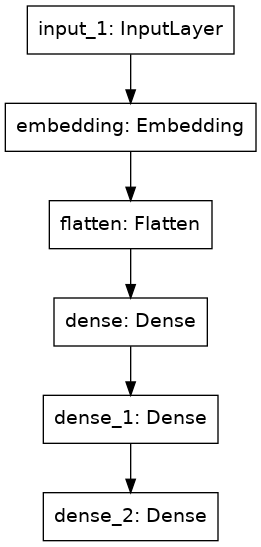

In [17]:
inputs = tf.keras.Input(shape=(X_train.shape[1],))

embedding = tf.keras.layers.Embedding(
    input_dim=10000, ### no of words considered
    output_dim=64   ### size of vector, higher implies higher intutive
)(inputs)

flatten = tf.keras.layers.Flatten()(embedding)

dense_1 = tf.keras.layers.Dense(128, activation='relu')(flatten)
dense_2 = tf.keras.layers.Dense(128, activation='relu')(dense_1)

outputs = tf.keras.layers.Dense(len(cat_idx), activation='softmax')(dense_2)


model = tf.keras.Model(inputs, outputs)

print(model.summary())
tf.keras.utils.plot_model(model)

In [18]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    batch_size=32,
    epochs=100,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        )
    ]
)

### small accuracy as there are 41 categories

Epoch 1/100
718/718 [==============================] - 6s 8ms/step - loss: 3.6312 - accuracy: 0.0471 - val_loss: 2.8917 - val_accuracy: 0.2171
Epoch 2/100
718/718 [==============================] - 5s 7ms/step - loss: 2.3027 - accuracy: 0.3652 - val_loss: 2.5906 - val_accuracy: 0.3179
Epoch 3/100
718/718 [==============================] - 5s 7ms/step - loss: 1.1410 - accuracy: 0.6884 - val_loss: 3.0314 - val_accuracy: 0.3132
Epoch 4/100
718/718 [==============================] - 5s 6ms/step - loss: 0.4364 - accuracy: 0.8940 - val_loss: 3.8803 - val_accuracy: 0.3052
Epoch 5/100
718/718 [==============================] - 5s 7ms/step - loss: 0.1469 - accuracy: 0.9685 - val_loss: 4.7692 - val_accuracy: 0.2979
Epoch 6/100
718/718 [==============================] - 5s 6ms/step - loss: 0.0625 - accuracy: 0.9864 - val_loss: 5.4889 - val_accuracy: 0.2941
Epoch 7/100
718/718 [==============================] - 5s 7ms/step - loss: 0.0309 - accuracy: 0.9938 - val_loss: 6.0503 - val_accuracy: 0.2923

In [19]:
print("Test Accuracy: {:.2f}%".format(model.evaluate(X_test, y_test, verbose=0)[1] * 100))

Test Accuracy: 32.44%


In [20]:
y_pred = np.argmax(model.predict(X_test), axis=1)

cm = confusion_matrix(y_test, y_pred)
clr = classification_report(y_test, y_pred, target_names=list(cat_idx.keys()))
print(clr)

                precision    recall  f1-score   support

         CRIME       0.39      0.48      0.43       293
 ENTERTAINMENT       0.20      0.22      0.21       279
    WORLD NEWS       0.24      0.03      0.05       280
        IMPACT       0.11      0.12      0.11       293
      POLITICS       0.49      0.08      0.14       324
    WEIRD NEWS       0.18      0.12      0.14       302
  BLACK VOICES       0.32      0.08      0.13       329
         WOMEN       0.21      0.34      0.26       324
        COMEDY       0.24      0.40      0.30       282
  QUEER VOICES       0.52      0.46      0.49       333
        SPORTS       0.41      0.40      0.40       297
      BUSINESS       0.35      0.09      0.14       298
        TRAVEL       0.36      0.26      0.30       293
         MEDIA       0.27      0.54      0.36       259
          TECH       0.43      0.37      0.40       297
      RELIGION       0.34      0.42      0.38       291
       SCIENCE       0.48      0.38      0.43  

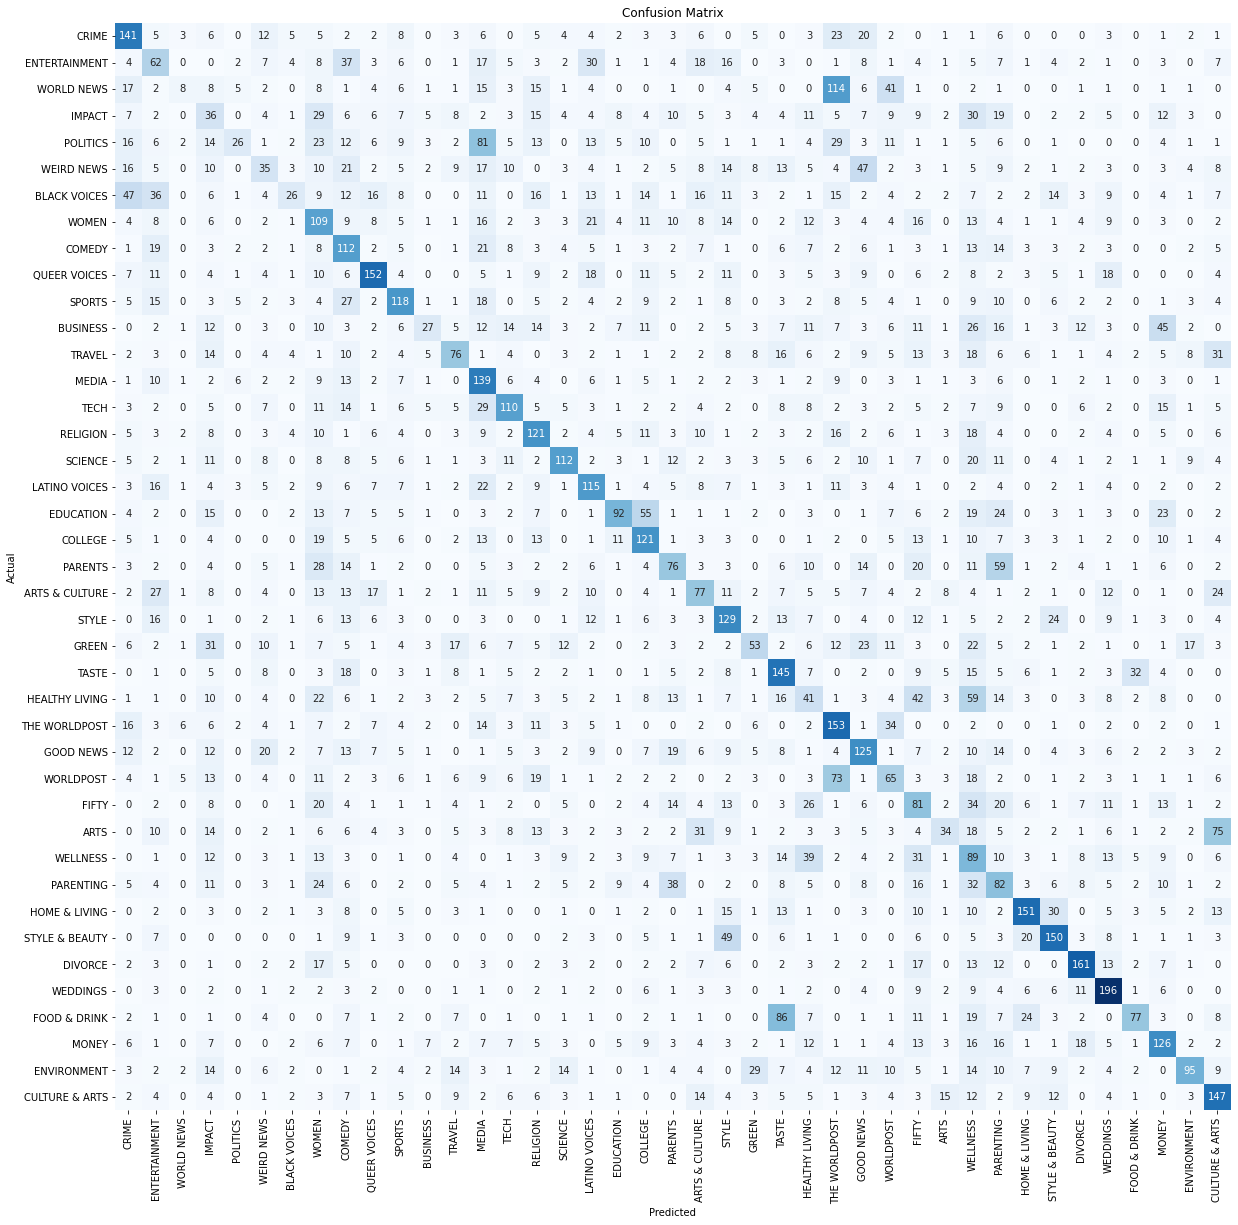

In [21]:
plt.figure(figsize=(20, 20))
sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
plt.xticks(ticks=np.arange(len(cat_idx)) + 0.5, labels=list(cat_idx.keys()), rotation=90)
plt.yticks(ticks=np.arange(len(cat_idx)) + 0.5, labels=list(cat_idx.keys()), rotation=0)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
### works fine